In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from scipy.stats import boxcox

In [3]:
df = pd.read_csv('upa_event_ts.csv')
df = df.sort_values(by=['datetime'])

In [4]:
df.head(2)

,datetime,code,day,hour,minute,day_name,datetime.1,count,date,month
0,1535414421259,combinedproducts-search-e-flightresults-filter...,27,20,0,Monday,1535414421259,1,2018-08-27 20:00:21.259,8
1,1535414451815,transfers-checkout-e-credit-card-completed,27,20,0,Monday,1535414451815,2,2018-08-27 20:00:51.815,8


In [215]:
def get_ts(code,df, apply_box_cox = True, lamb = 0.5):
    values = np.float32(df[df.code == code]['count'].values)
    dim = values.shape[0]
    index = np.int64(np.array([x for x in range(1,dim+1)]))
    index = index.reshape(1,dim)
    values = values.reshape(1,dim)
    if (apply_box_cox):
        values = boxcox(values, lamb)
    return (index, values)

In [216]:
def generate_timeseries_csv():
    codes = ['cars-search','cars-checkout','cars-thanks', 'hotels-search','hotels-checkout','hotels-thanks','flights-search','flights-checkout','flights-thanks']
    for code in codes:
        x_ts, y_ts = get_ts(code, df)
        t = pd.Series(data=y_ts.flat, index=x_ts.flat)
        t.to_csv(code + ".csv")

In [267]:
LEARNING_RATE = 1.0
PERIOD = 1008
PI = np.pi
ALPHA_REG = 0
THRESHOLD = 900
TEST = 144*4

In [268]:
x_ts, y_ts = get_ts('flights-thanks',df, apply_box_cox=True, lamb=0.5)
x_ts_train = x_ts[:, :-TEST]
y_ts_train = y_ts[:, :-TEST]

In [269]:
x_train = tf.constant(x_ts_train,dtype=tf.float32)

y_train = tf.constant(y_ts_train,dtype=tf.float32)

x = tf.constant(x_ts,dtype=tf.float32)

y = tf.constant(y_ts,dtype=tf.float32)

multipliers = tf.constant([(x*2*PI)/PERIOD for x in range(THRESHOLD,PERIOD)], dtype=tf.float32)

amplitudes_cos = tf.Variable(tf.random_uniform([1, PERIOD - THRESHOLD], -10, 10, seed=42))

amplitudes_sin = tf.Variable(tf.random_uniform([1, PERIOD - THRESHOLD], -10, 10, seed=42))

bias = tf.Variable(tf.zeros([1]))

sin_part = tf.reduce_sum(tf.sin(tf.transpose(x_train) * multipliers) * amplitudes_sin, 1)

cos_part = tf.reduce_sum(tf.cos(tf.transpose(x_train) * multipliers) * amplitudes_cos, 1)

y_pred = sin_part + cos_part + bias

error = y_pred - y_train

regularizer = ALPHA_REG * tf.nn.l2_loss(amplitudes_cos) + ALPHA_REG * tf.nn.l2_loss(amplitudes_sin)

mse = tf.reduce_mean(tf.square(error) + regularizer, name="mse")

op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(mse)

sin_part = tf.reduce_sum(tf.sin(tf.transpose(x) * multipliers) * amplitudes_sin, 1)

cos_part = tf.reduce_sum(tf.cos(tf.transpose(x) * multipliers) * amplitudes_cos, 1)

y_ext = sin_part + cos_part + bias


In [270]:
n_epochs = 400
init = tf.global_variables_initializer()
sess = tf.Session()
with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            sess.run(op)
            print("epoch %s, mse = %s " % (epoch, mse.eval()))
        y_p = y_pred.eval()
        y_extended = y_ext.eval()

epoch 0, mse = 2951.5732 
epoch 1, mse = 2133.7896 
epoch 2, mse = 1509.6316 
epoch 3, mse = 1050.3666 
epoch 4, mse = 726.94037 
epoch 5, mse = 511.92572 
epoch 6, mse = 379.89322 
epoch 7, mse = 307.68268 
epoch 8, mse = 275.43317 
epoch 9, mse = 267.60013 
epoch 10, mse = 272.8623 
epoch 11, mse = 283.13565 
epoch 12, mse = 292.6494 
epoch 13, mse = 297.45258 
epoch 14, mse = 295.20663 
epoch 15, mse = 285.08887 
epoch 16, mse = 267.52237 
epoch 17, mse = 243.80643 
epoch 18, mse = 215.85889 
epoch 19, mse = 185.93484 
epoch 20, mse = 156.21922 
epoch 21, mse = 128.46248 
epoch 22, mse = 103.879944 
epoch 23, mse = 83.24766 
epoch 24, mse = 66.97789 
epoch 25, mse = 55.10823 
epoch 26, mse = 47.28308 
epoch 27, mse = 42.821404 
epoch 28, mse = 40.867016 
epoch 29, mse = 40.537872 
epoch 30, mse = 41.02173 
epoch 31, mse = 41.63552 
epoch 32, mse = 41.86732 
epoch 33, mse = 41.389355 
epoch 34, mse = 40.053547 
epoch 35, mse = 37.88894 
epoch 36, mse = 35.075924 
epoch 37, mse = 31.8

epoch 309, mse = 1.2795067 
epoch 310, mse = 1.279507 
epoch 311, mse = 1.2795069 
epoch 312, mse = 1.2795069 
epoch 313, mse = 1.2795072 
epoch 314, mse = 1.2795073 
epoch 315, mse = 1.2795073 
epoch 316, mse = 1.2795073 
epoch 317, mse = 1.2795072 
epoch 318, mse = 1.2795073 
epoch 319, mse = 1.2795073 
epoch 320, mse = 1.2795073 
epoch 321, mse = 1.2795069 
epoch 322, mse = 1.2795069 
epoch 323, mse = 1.2795067 
epoch 324, mse = 1.2795068 
epoch 325, mse = 1.2795072 
epoch 326, mse = 1.279507 
epoch 327, mse = 1.2795067 
epoch 328, mse = 1.2795068 
epoch 329, mse = 1.2795068 
epoch 330, mse = 1.2795072 
epoch 331, mse = 1.2795069 
epoch 332, mse = 1.2795069 
epoch 333, mse = 1.2795072 
epoch 334, mse = 1.279507 
epoch 335, mse = 1.279507 
epoch 336, mse = 1.2795072 
epoch 337, mse = 1.2795072 
epoch 338, mse = 1.2795072 
epoch 339, mse = 1.2795072 
epoch 340, mse = 1.279507 
epoch 341, mse = 1.2795072 
epoch 342, mse = 1.2795069 
epoch 343, mse = 1.2795069 
epoch 344, mse = 1.279506

/Users/claudio.gauna/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/claudio.gauna/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


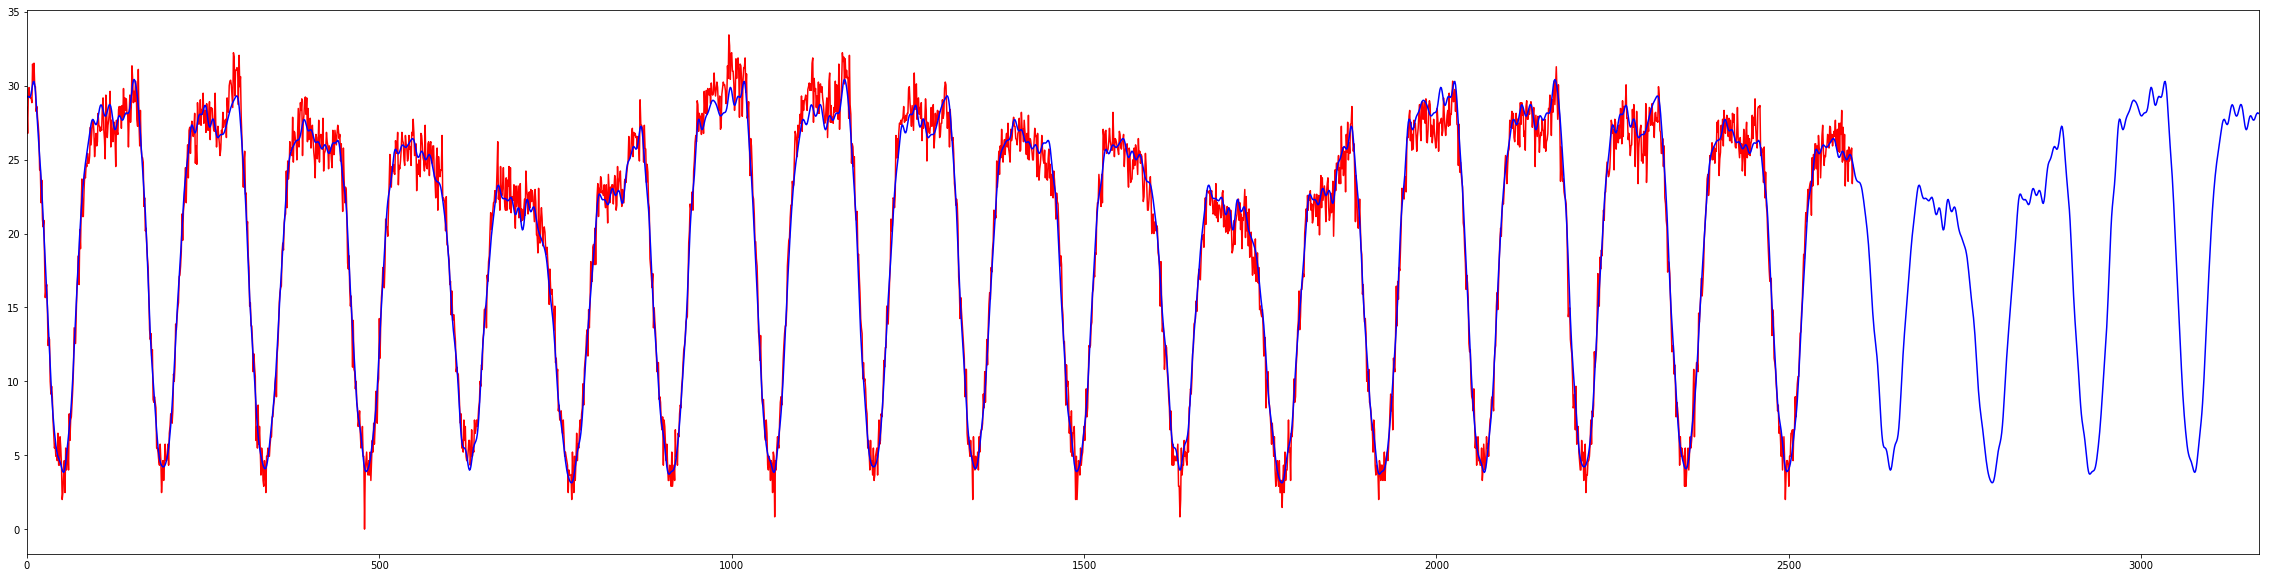

In [274]:
plt.figure(figsize=(40,10))
sbn.tsplot(y_ts_train, color="red")
sbn.tsplot(y_extended, color="blue")

In [272]:
noise = y_ts - y_extended

/Users/claudio.gauna/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


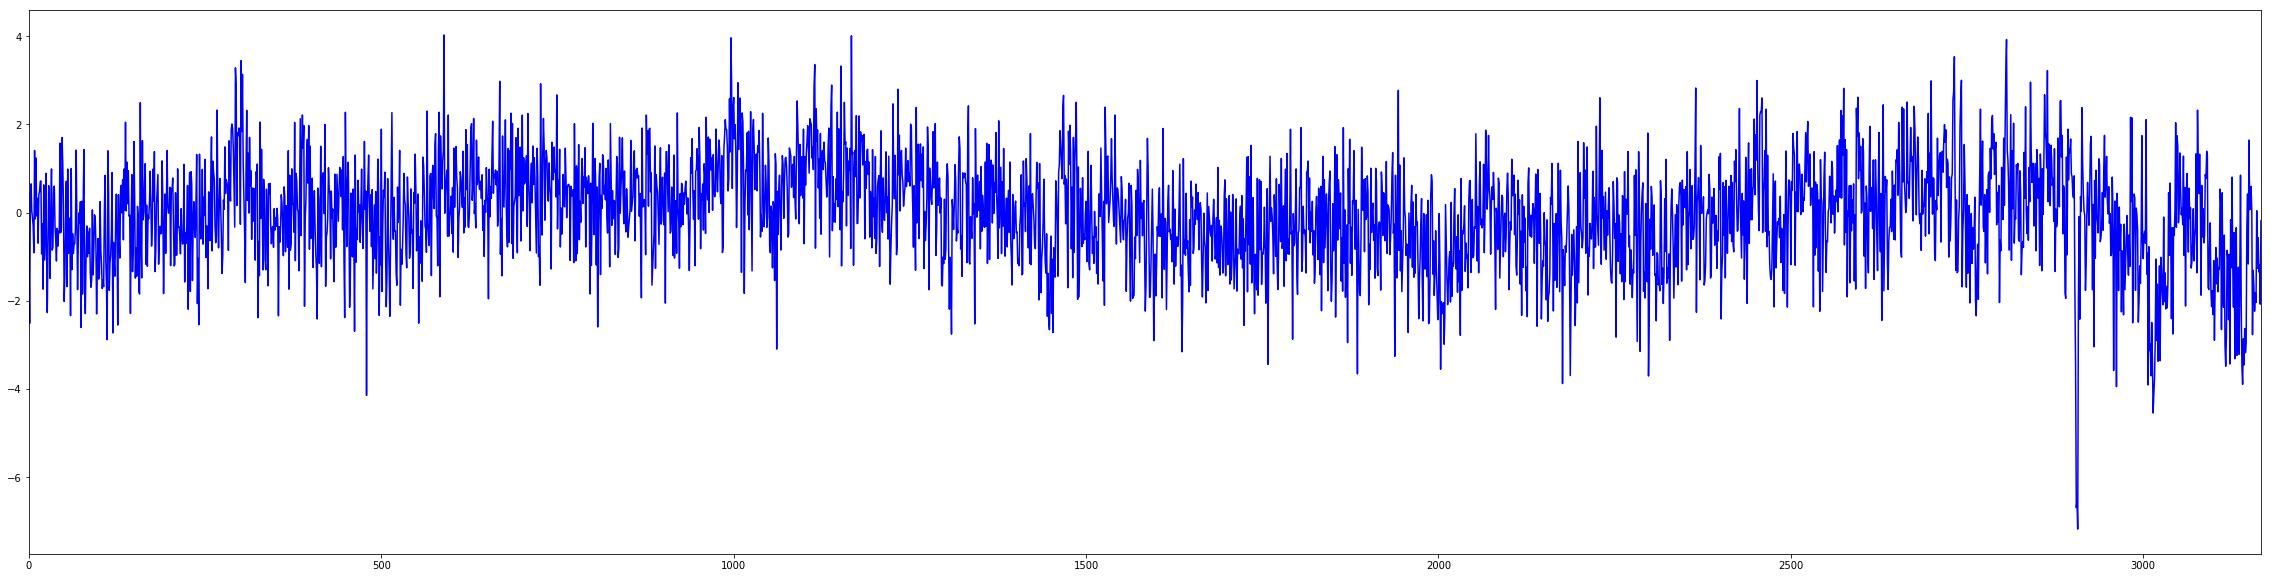

In [273]:
plt.figure(figsize=(40,10))
sbn.tsplot(noise, color="blue")